In [1]:
# Build Recurrent Neural Net Learning Machine (RNNLM) via model specified in https://arxiv.org/pdf/1901.03860.pdf

In [2]:
import numpy as np
import tenncor as tc
import librosa
import librosa.display

In [3]:
y, sr = librosa.load(librosa.util.example_audio_file())
melout = librosa.feature.melspectrogram(y=y, sr=sr)

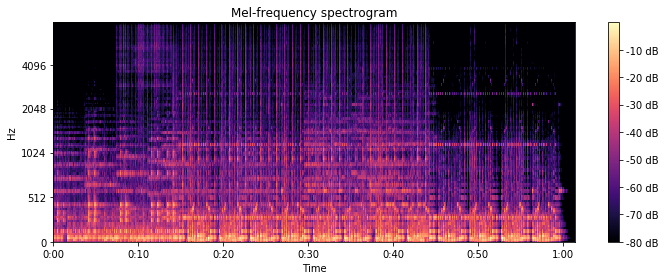

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(melout, ref=np.max)
librosa.display.specshow(S_dB, 
    x_axis='time',
    y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [5]:
def weight_init(shape, label):
    return tc.variable(np.random.uniform(-0.05, 0.05, shape.as_list()), label)

melin = tc.EVariable(list(melout.shape), label="melin")
ftinput = tc.permute(melin, [2, 0, 1])
finetuned = tc.layer.link([
    tc.layer.conv([5, 5], 1, 1,
        weight_init=tc.norm_xavier_init(0.5),
        zero_padding=[2, 2]), 
    tc.layer.conv([5, 5], 1, 1,
        weight_init=tc.norm_xavier_init(0.5),
        zero_padding=[2, 2]), 
    tc.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
        seq_dim = 2, weight_init=weight_init,
        bias_init=tc.zero_init()),
    tc.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
        seq_dim = 2, weight_init=weight_init,
        bias_init=tc.zero_init()),
    tc.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
        seq_dim = 2, weight_init=weight_init,
        bias_init=tc.zero_init()),
    tc.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
        seq_dim = 2, weight_init=weight_init,
        bias_init=tc.zero_init()),
    tc.layer.gru(tc.Shape([melout.shape[1], 1]), 1, 128,
        seq_dim = 2, weight_init=weight_init,
        bias_init=tc.zero_init()),
], ftinput)
fineout = tc.permute(finetuned, [1, 2, 0])
print(melin.shape())
print(fineout.shape())

[ 128 2647]
[ 128 2647]


In [6]:
sess = tc.Session()
sess.track([fineout])

melin.assign(melout)
sess.update()
ftout = fineout.get()
print(ftout)

[[ 4.66198191e-11  1.44554951e-10  2.72665068e-11 ... -5.38995075e-19
   1.31690115e-17  3.27559155e-17]
 [ 2.78631562e-10  9.18484178e-10  8.76408723e-10 ... -2.36156376e-17
   1.19237192e-17  9.00340370e-17]
 [ 4.15588453e-10  1.56669944e-09  1.22153732e-09 ... -1.34102481e-16
  -1.67036221e-17  1.33994485e-16]
 ...
 [ 5.66824369e-15 -7.01044617e-15 -5.32282992e-14 ...  5.29722813e-20
   1.00846978e-19 -1.79576226e-20]
 [ 5.62007843e-15 -6.64105848e-15 -5.06683928e-14 ...  5.45695961e-20
   8.85306853e-20 -2.38141809e-20]
 [ 5.88499730e-15 -6.89160956e-15 -4.77499848e-14 ...  5.54339417e-20
   7.47880487e-20 -2.86655241e-20]]


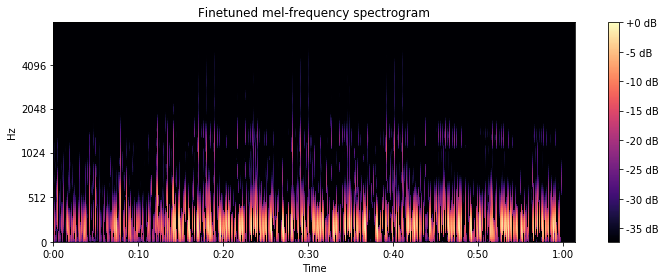

In [8]:
plt.figure(figsize=(10, 4))
S_dB2 = librosa.power_to_db(ftout, ref=np.max)
librosa.display.specshow(S_dB2, 
    x_axis='time',
    y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Finetuned mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [7]:
# Idea: 
# map vocabulary to pre-trained embedding before training in RNNLM